In [1]:
%load_ext autoreload
%autoreload 2

# Rx Fire Policy replication plots

In this notebook we generate the main plot of our simulations results and some supplementary figures explaining the simulation process: 
 - Fig 4: Main results from simulation: cost-benefit ratio
 - Sup 7: Severity-Emissions response function
 - Sup 6: Descriptives of simulation process.

In [2]:
import os
import matplotlib
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prescribed.estimate.simulations import (
    make_model,
    calculate_benefits,
)
from prescribed.plot import template_plots

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"
sim_path = "/mnt/sherlock/oak/prescribed_data/processed/simulations"

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


In [4]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet to make it nicer for DuckDB.
# Here we bottom code dnbr to avoid weird and large negative values
dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Because of some dnbr issues (buffered data), we need to remove some of the data
# by using the templates we have from MTBS (remove grids in the buffer). We could
# normally do this by a spatial join, but we have a lot of data and it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Add land type data
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)
treatments_dnbr = treatments_dnbr.merge(
    land_type[["grid_id", "land_type"]], on="grid_id"
)

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    ["year", "Event_ID", "Incid_Name", "grid_id", "Ig_Date", "Incid_Type"],
    as_index=False,
).dnbr.max()

treatments_dnbr_clean.to_parquet("../data/dnbr.parquet")


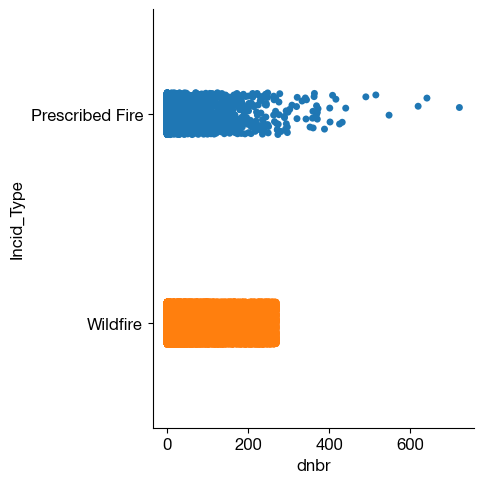

In [16]:
plot_data = treatments_dnbr_clean[
    treatments_dnbr_clean.Event_ID.isin(
        mtbs[
            mtbs.Incid_Type.isin(["Prescribed Fire", "Wildfire"])
        ].Event_ID.tolist()
    )
]

# Filter all Wildifre observations whose dnbr is larger than 269
plot_data = plot_data[
    ~((plot_data.Incid_Type == "Wildfire") & (plot_data.dnbr > 269))
]

sns.catplot(data=plot_data, y="Incid_Type", x="dnbr", hue="Incid_Type")

In [5]:
rx_fire_dnbr = dnbr[
    dnbr.event_id.isin(
        mtbs[mtbs.Incid_Type == "Prescribed Fire"].Event_ID.tolist()
    )
].dnbr.mean()
rx_fire_dnbr

41.715572

In [6]:
dnbr[
    dnbr.event_id.isin(
        mtbs[mtbs.Incid_Type == "Prescribed Fire"].Event_ID.tolist()
    )
].dnbr.median()

9.304087

## Sup Fig 7: Explore $\Delta$ NBR relationship with PM $_{2.5}$ concentrations

In [69]:
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.1]

# # Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

# Change year type to avoid problems
smoke_linked["year"] = smoke_linked.year.astype(int)

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

# Estimate boostrap confidence intervals for marginal effects

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)


# Multiply the second column of coef by the range of severities
boot_samples = []
for i in range(999):
    boot_samples.append(coefs[i, 0] + (2 * coefs[i, 1] * range_severity))

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 0.5, 97.5], axis=0)

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:42<00:00, 23.72it/s]


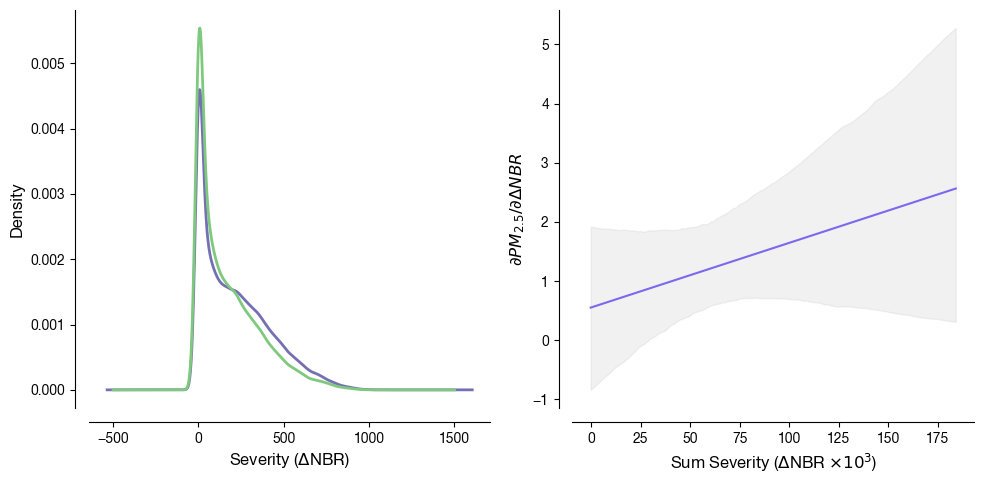

In [73]:
# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
treatments_dnbr[treatments_dnbr.year > 2006].dnbr.plot.density(
    ax=ax[0], color="#7570b3", linewidth=2
)
treatments_dnbr[
    (treatments_dnbr.year > 2006)
    & (treatments_dnbr.Event_ID.isin(smoke_linked.event_id.tolist()))
].dnbr.plot.density(ax=ax[0], color="#7fc97f", linewidth=2)

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# # Add a legend for the two density lines
# ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions
ax[1].fill_between(
    range_severity / 1000,
    bounds[0],
    bounds[2],
    alpha=0.2,
    color="#bdbdbd",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity / 1000,
    np.mean(boots, axis=0),
    color="mediumslateblue",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR $\\times 10^{3} $)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)


plt.tight_layout()

# Save plot as a vector graphic
plt.savefig("../figs/severity_emissions_link.pdf", bbox_inches="tight", dpi=400)

## Fig 4: Discounted benefit-cost ratio for two types of simulation (w/ and wo/ spillovers)

In [54]:
# Set seed numpy
np.random.seed(42)

# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked[smoke_linked.coverage_threshold == 0.1]

# Avoid prediction errors
smoke_linked["year"] = smoke_linked.year.astype(int)

# Remove outliers from smoke linked data
# smoke_linked = smoke_linked[
#     (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
#     & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
# ]

benefits_no_spill, sims = calculate_benefits(
    n_treats=4000,
    path=f"{sim_path}/policy_no_spill_4000_large_4000",
    # path="../data/policy_no_spill_4000/",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=60,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)

benefits_no_spill["treatment"] = "No Spill"

benefits_spill, sims = calculate_benefits(
    n_treats=1000,
    path=f"{sim_path}/policy_spill_large_150",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=60,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_spill["treatment"] = "Spillovers"
benefits = pd.concat([benefits_no_spill, benefits_spill])

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:42<00:00, 23.63it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:458: UserWarning: 1.0402% of rows were removed
  warnings.warn(f"{prop:.4f}% of rows were removed")
Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:29<00:00, 34.01it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:458: UserWarning: 0.2782% of rows were removed
  warnings.warn(f"{prop:.4f}% of rows were removed")
Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:30<00:00, 33.20it/s]


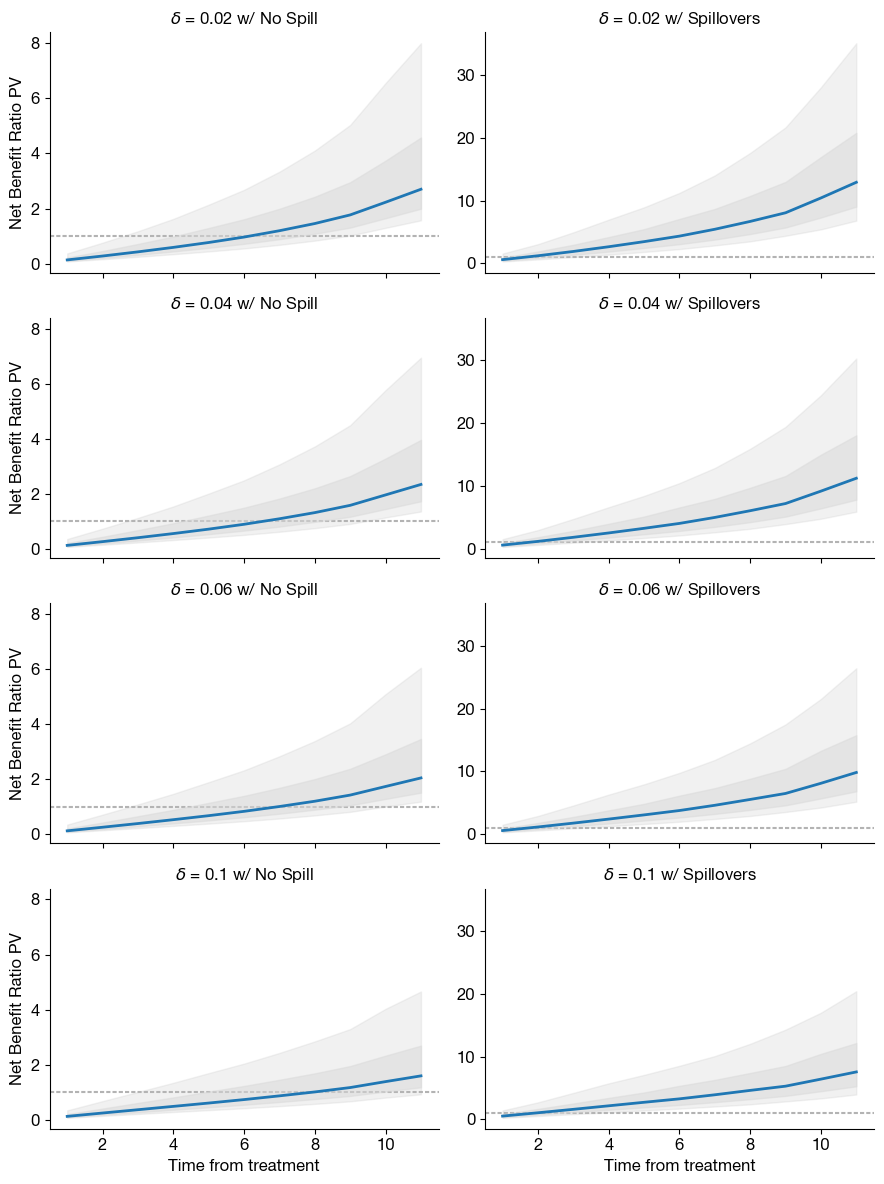

In [67]:
# remove weird ratios
benefits = benefits.dropna()

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits,
    x="lag",
    y="ratio",
    # hue="discount_rate",
    row="discount_rate",
    col="treatment",
    # palette="crest",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)

colors = sns.color_palette(
    "crest", n_colors=len(mean_benefits["discount_rate"].unique())
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.1, 0.90])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.treatment,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.1],
        q_dr[0.9],
        color="#bdbdbd",
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
    )

plt.tight_layout()

# Save plot
plt.savefig(
    "../figs/pv_benefits_pe_avg.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


### Plot example of simulation fire event

In [72]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select grid_id, year_treat, event_id, event_name, mean(sim_benefit) as mean_benefit
from benefits_grid_simulation
where event_id == 'CA3720111927220200905' and year
group by grid_id, year_treat, event_id, event_name
""").to_df()

grids_fire = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "lat", "lon"]]

df = df.merge(grids_fire, on="grid_id")

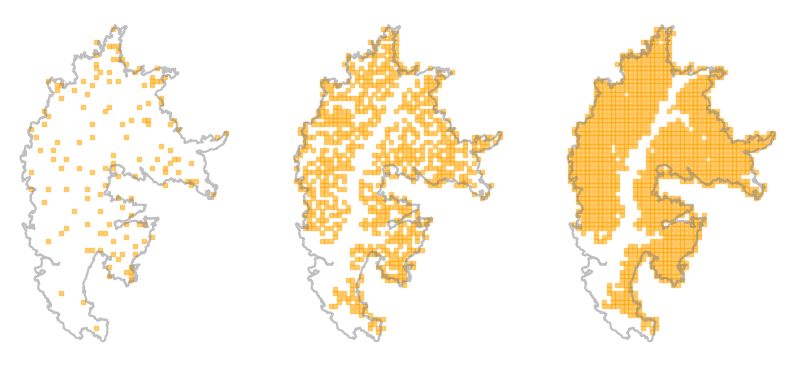

In [74]:
# Total treats
treat_time = df.groupby(
    ["grid_id", "lat", "lon"], as_index=False
).year_treat.first()


years_plot = [2010, 2015, 2020]

# Plot each year in df as scatter
fig, ax = plt.subplots(1, len(years_plot), figsize=(10, 10))

for ax, year in zip(ax.flatten(), years_plot):
    data = treat_time[treat_time.year_treat <= year]
    ax.scatter(data.lon, data.lat, marker=",", s=5, c="orange", alpha=0.5)
    mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
        ax=ax, color="gray", alpha=0.5
    )
    ax.axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/treats_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [75]:
(treat_time.groupby("year_treat").grid_id.count().cumsum()) / 1772

year_treat
2010    0.080135
2011    0.161400
2012    0.239278
2013    0.308691
2014    0.388262
2015    0.467833
2016    0.544582
2017    0.628104
2018    0.694695
2019    0.764108
Name: grid_id, dtype: float64

In [76]:
df_complete = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "dnbr", "lat", "lon"]].merge(
    df, on=["grid_id", "lat", "lon"], how="left"
)
df_complete["mean_benefit"] = df_complete.mean_benefit.fillna(df_complete.dnbr)

df_complete["pixel_benefit"] = df_complete.dnbr - df_complete.mean_benefit

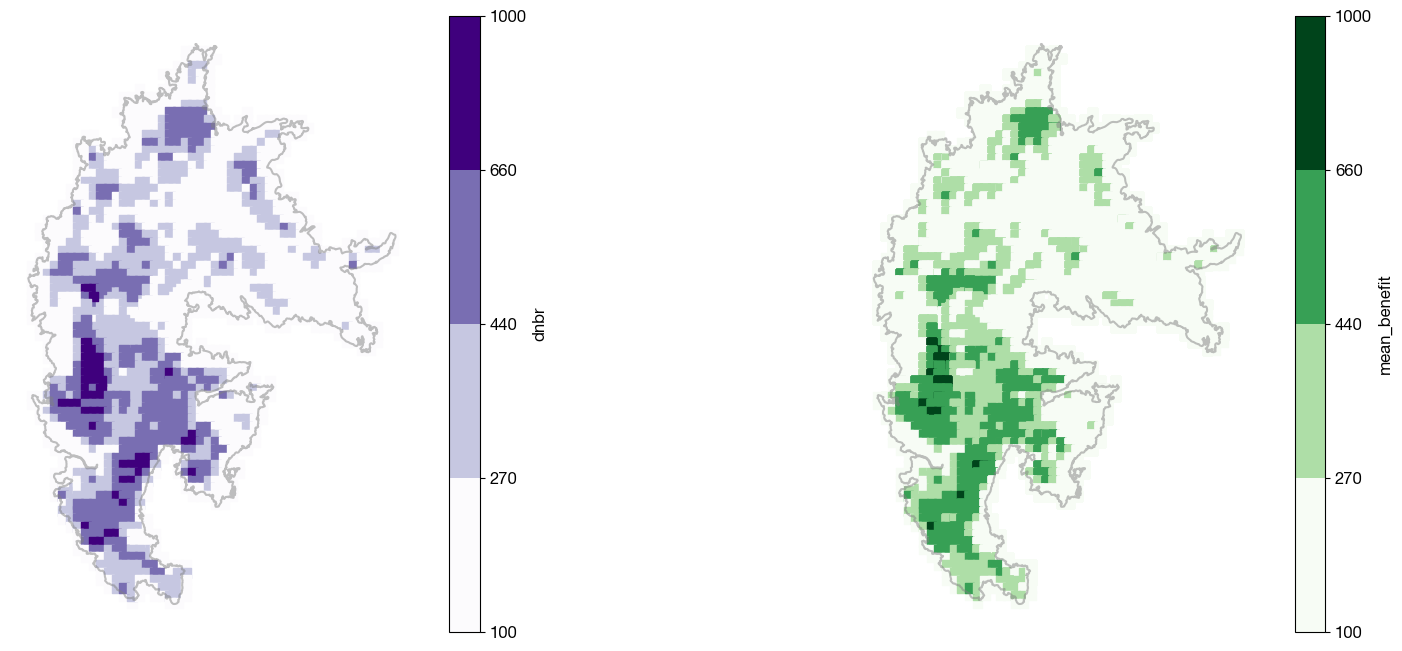

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Unify the colorbar for both plots
vmin = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.min()
vmax = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.max()

df_complete.plot(
    x="lon",
    y="lat",
    kind="scatter",
    c="mean_benefit",
    s=45,
    marker=",",
    ax=ax[1],
    cmap="Greens",
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[1], color="gray", alpha=0.5
)

treatments_dnbr[treatments_dnbr.Event_ID == "CA3720111927220200905"].plot(
    ax=ax[0],
    x="lon",
    y="lat",
    kind="scatter",
    c="dnbr",
    s=50,
    marker=",",
    cmap="Purples",
    colorbar=True,
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[0], color="gray", alpha=0.5
)

ax[0].axis("off")
ax[1].axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/fire_creek_benefit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [18]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select *
from benefits_grid_simulation
""").to_df()

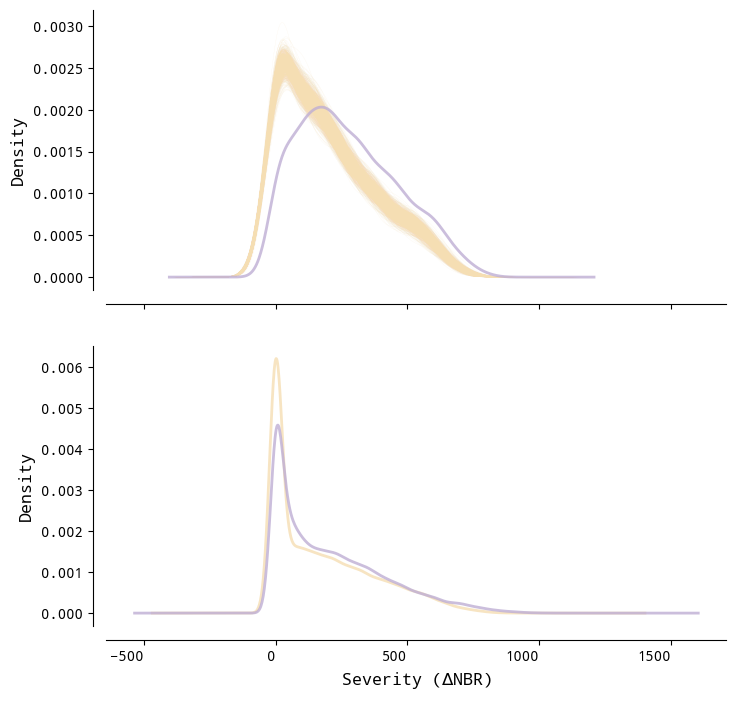

In [ ]:
# Plot distribution of benefits
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

sims_event = df[df.event_id == "CA3720111927220200905"]

for sim in df.sim.unique():
    sims_event[(sims_event.sim == sim)].sim_benefit.plot.density(
        ax=ax[0], color="wheat", alpha=0.5, linewidth=0.1
    )

treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.plot.density(ax=ax[0], color="#beaed4", linewidth=2, alpha=0.8)

# sims_event.groupby("grid_id").sim_benefit.mean().plot.density(
#     ax=ax[0], color="orange", linewidth=2, alpha=0.5
# )

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Plot the same, but for all the events
all_sims = (
    df.groupby(["grid_id"])
    .sim_benefit.min()
    .plot.density(ax=ax[1], color="wheat", linewidth=2, alpha=0.8)
)

# for sim in df.sim.unique():
#     all_sims[(all_sims.sim == sim)].sim_benefit.plot.density(
#         ax=ax[1], color="wheat", alpha=0.5, linewidth=0.1
#     )

treatments_dnbr[
    (treatments_dnbr.year > 2010) & (treatments_dnbr.year < 2021)
].dnbr.plot.density(ax=ax[1], color="#beaed4", linewidth=2, alpha=0.8)

# all_sims.groupby("grid_id").sim_benefit.median().plot.density(
#     ax=ax[1], color="orange", linewidth=2, alpha=0.5
# )

# Apply template
template_plots(ax[1], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Save plot as PDF
plt.savefig(
    "../figs/benefits_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

### Check that this is a good fit of $\Delta \text{NBR}$ for $PM_{2.5}$

In [9]:
from prescribed.plot import get_best_poly_fit

# Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

get_best_poly_fit(
    y=smoke_linked[["sum_contrib"]],
    X=smoke_linked[["sum_severity", "total_pixels", "total_days"]],
    degrees=range(1, 10),
)

{'degrees': range(1, 10),
 'rmses': [38968.01918144658,
  38855.25576425268,
  42455.39000671866,
  52498.528445898584,
  60284.46673012927,
  65188.90371827918,
  67983.45088023301,
  69825.16129452967,
  71267.4014130407],
 'best_degree': 2}